In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_images/63836.png
/kaggle/input/UBC-OCEAN/train_images/56117.png
/kaggle/input/UBC-OCEAN/train_i

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 
print("Tenserflow Version" + tf.__version__)

Tenserflow Version2.13.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [4]:
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
train_df

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [5]:
test_df = pd.read_csv("/kaggle/input/UBC-OCEAN/test.csv")
test_df

,image_id,image_width,image_height
0,41,28469,16987


In [6]:
pd.read_csv("/kaggle/input/UBC-OCEAN/sample_submission.csv")

,image_id,label
0,41,HGSC


In [7]:
train_df.nunique()

image_id        538
label             5
image_width     508
image_height    508
is_tma            2
dtype: int64

In [8]:
train_df['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

In [9]:
train_df.isnull().sum()

image_id        0
label           0
image_width     0
image_height    0
is_tma          0
dtype: int64

In [10]:
train_dir = '/kaggle/input/UBC-OCEAN/train_thumbnails'
test_dir = '/kaggle/input/UBC-OCEAN/test_thumbnails'
train_df_tma = train_df[train_df['is_tma']==True]
train_df_no_tma = train_df[train_df['is_tma']==False]
train_df_no_tma['image_id_path'] = [f"{train_dir}/{i}_thumbnail.png" 
                                    for i in train_df_no_tma['image_id']]
test_df['image_id_path'] = [f"{test_dir}/{i}_thumbnail.png" 
                                    for i in test_df['image_id']]
print(train_df_no_tma.shape)
train_df_no_tma

(513, 6)


,image_id,label,image_width,image_height,is_tma,image_id_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
3,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
4,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
5,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


In [11]:
test_df

,image_id,image_width,image_height,image_id_path
0,41,28469,16987,/kaggle/input/UBC-OCEAN/test_thumbnails/41_thu...


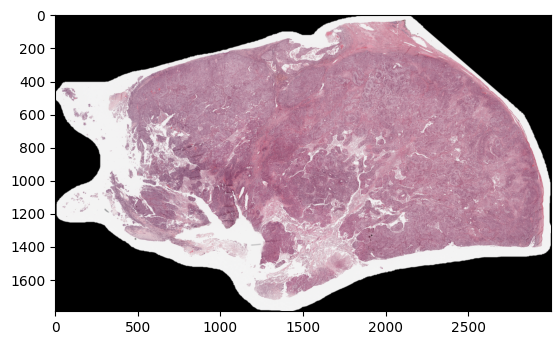

In [12]:
img = test_df["image_id_path"][0]
path = os.path.join(img)
image = plt.imread(path)
image = plt.imshow(image)

In [13]:
train_df_tma['image_id_path'] = [f"{train_dir}/{i}.png" 
                                    for i in train_df_tma['image_id']]
print(train_df_tma.shape)
train_df_tma.head(5)

(25, 6)


,image_id,label,image_width,image_height,is_tma,image_id_path
2,91,HGSC,3388,3388,True,/kaggle/input/UBC-OCEAN/train_thumbnails/91.png
37,4134,MC,2964,2964,True,/kaggle/input/UBC-OCEAN/train_thumbnails/4134.png
76,8280,HGSC,2964,2964,True,/kaggle/input/UBC-OCEAN/train_thumbnails/8280.png
83,9200,MC,3388,3388,True,/kaggle/input/UBC-OCEAN/train_thumbnails/9200.png
112,13568,LGSC,2964,2964,True,/kaggle/input/UBC-OCEAN/train_thumbnails/13568...


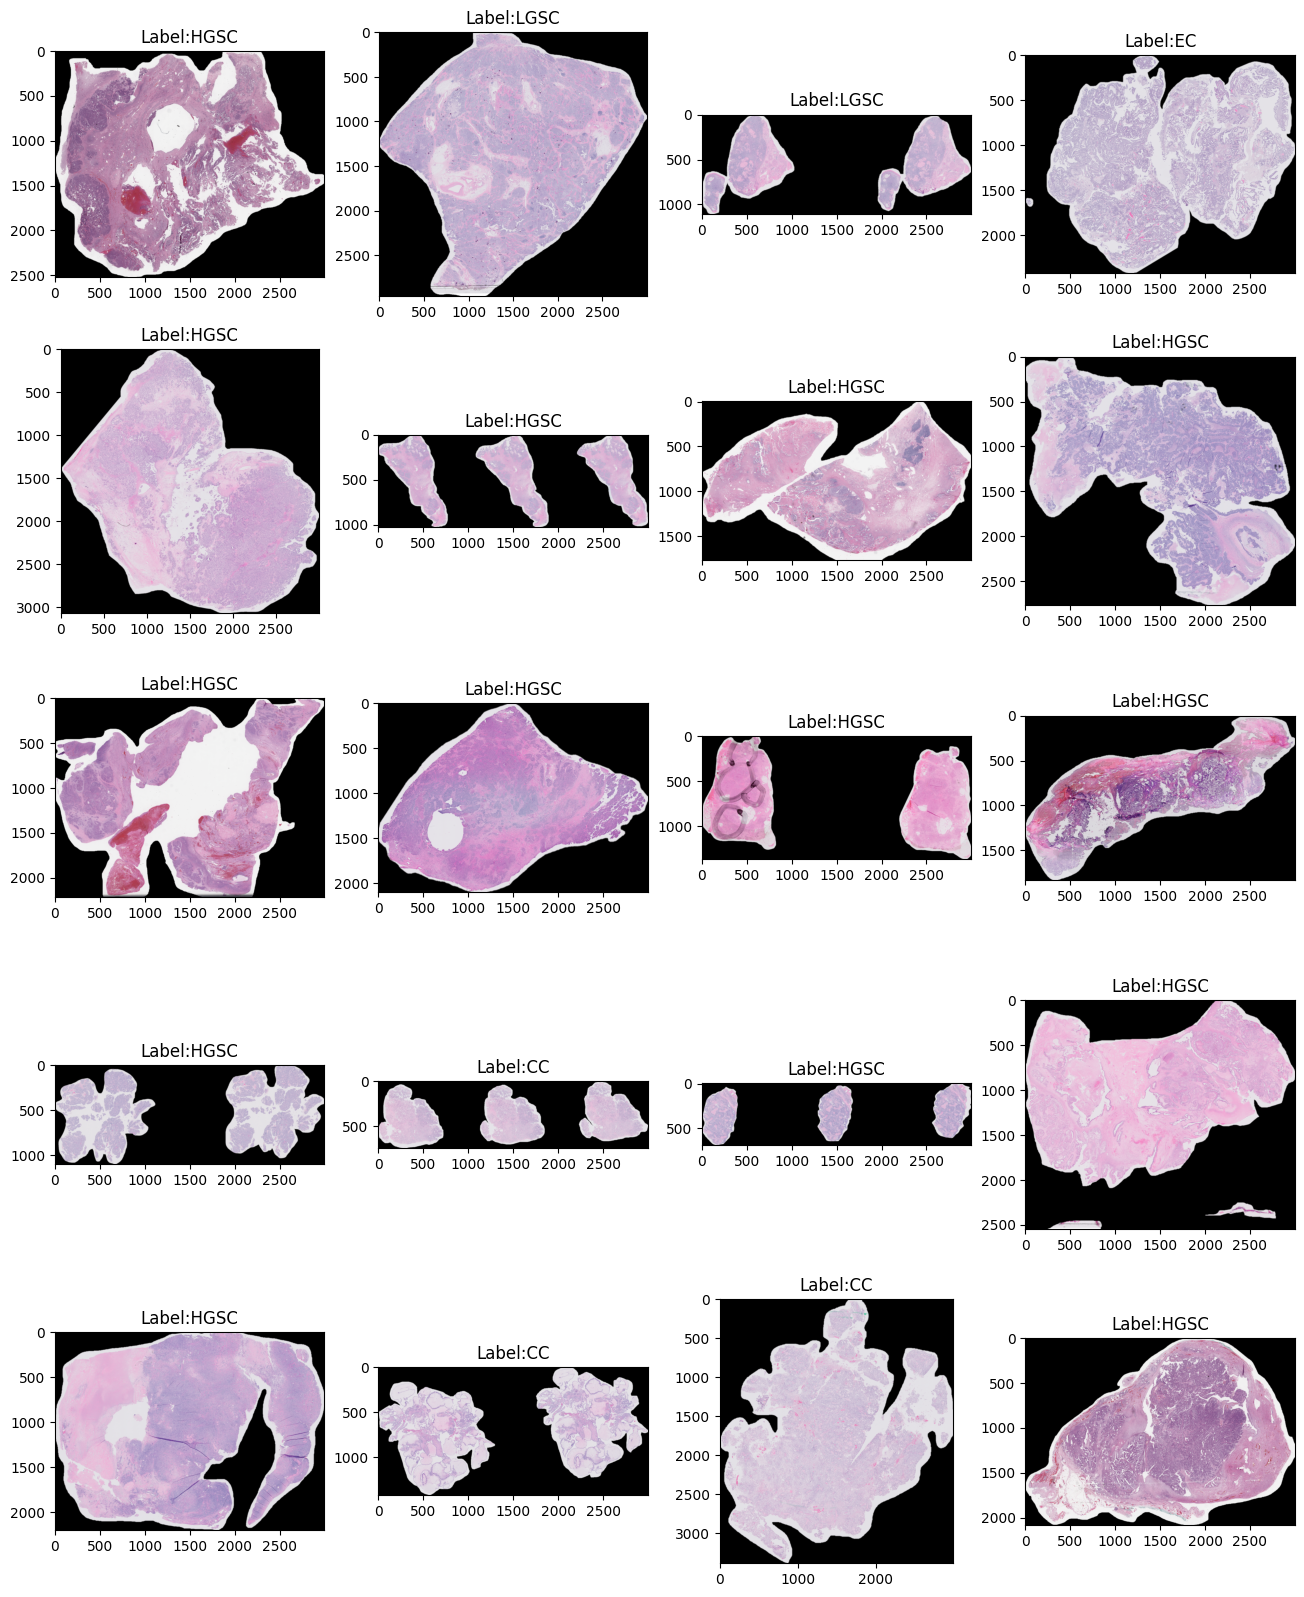

In [14]:
plt.figure(figsize=(16,24))
j=1
for img, lb in zip(train_df_no_tma['image_id_path'][:20],train_df_no_tma['label'][:20]):
    plt.subplot(6,4,j)
    path = os.path.join(img)
    image = plt.imread(path)
    image = plt.imshow(image)
    plt.title(f"Label:{lb}")
    j+=1

In [15]:
# enhancing image contrast
def contrast_enhance(img):
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # different values for the limit and grid size can be applied:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced_img

In [16]:
# images from the train folder
data_train = []
for i in range(len(train_df_no_tma['image_id_path'])):
    img = Image.open(train_df_no_tma['image_id_path'].values[i])
    image = img.resize((224,224))
    image = image.convert("RGB")
    image = np.array(image)
    image_data = contrast_enhance(image)
    data_train.append(image_data)
X_train = np.array(data_train)
print(X_train.shape)

(513, 224, 224, 3)


In [17]:
#test image processing
data_test = []
for i in range(len(test_df['image_id_path'])):
    img = Image.open(test_df['image_id_path'].values[i])
    image = img.resize((224,224))
    image = image.convert("RGB")
    image = np.array(image)
    image_data = contrast_enhance(image)
    data_test.append(image_data)
X_test = np.array(data_test)
print(X_test.shape)

(1, 224, 224, 3)


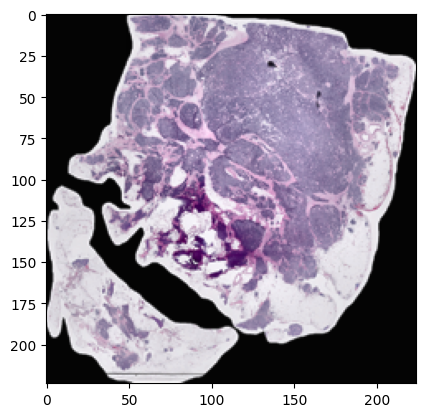

In [18]:
plt.imshow(X_train[150])

In [19]:
# train image set normalization.
X_train = X_train.astype('float32')
X_train /= 255.0

In [20]:
#one ot encoding for the labels
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE_label= LE.fit_transform(train_df_no_tma[['label']]) 
target = np.array(LE_label)
print(target.shape)

(513,)


In [21]:
train_df_no_tma['target']=target

In [22]:
train_df_no_tma.groupby('label').count()

,image_id,image_width,image_height,is_tma,image_id_path,target
label,,,,,,
CC,94,94,94,94,94,94
EC,119,119,119,119,119,119
HGSC,217,217,217,217,217,217
LGSC,42,42,42,42,42,42
MC,41,41,41,41,41,41


In [23]:
train_df_no_tma['target'].value_counts()

target
2    217
1    119
0     94
3     42
4     41
Name: count, dtype: int64

In [24]:
train_df_no_tma

,image_id,label,image_width,image_height,is_tma,image_id_path,target
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...,2
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...,3
3,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...,3
4,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...,1
5,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...,2
...,...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...,3
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...,4
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...,2
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...,2


**Image augumenation**

In [25]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        fill_mode='nearest',
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2)


In [26]:
aug_img = []
aug_labels = []
for x_batch, y_batch in datagen.flow(X_train, target,
                                     batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break
for x_batch, y_batch in datagen.flow(X_train, target,
                                     batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break
for x_batch, y_batch in datagen.flow(X_train, target,
                                 batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break
for x_batch, y_batch in datagen.flow(X_train, target,
                                     batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break
for x_batch, y_batch in datagen.flow(X_train, target,
                                     batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break
for x_batch, y_batch in datagen.flow(X_train, target,
                                     batch_size=len(X_train), shuffle=False):
    aug_img.extend(x_batch)
    aug_labels.extend(y_batch)
    break

In [27]:
aug_img = np.array(aug_img)
aug_labels = np.array(aug_labels)

#concatenate og data with augmented
X = np.concatenate((X_train, aug_img))
Y = np.concatenate((target, aug_labels))

from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state=101)

In [28]:
Y
print(Y.shape)

(3591,)


In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [30]:
from sklearn.model_selection import train_test_split
# X_tr,X_te,y_tr,y_te = train_test_split(X, Y,stratify = Y, 
#                                        test_size=0.33,
#                                       random_state=101)

In [31]:
import tensorflow_hub as hub

baseline = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2")

In [32]:
# set random seed
tf.random.set_seed(42)

# create the model using sequential API
model = tf.keras.Sequential([baseline,Dense(5, activation = "softmax")])

model.layers[0].trainable = True
# compile the model
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [33]:
Y2 = keras.utils.to_categorical(Y)
Y2.shape

(3591, 5)

In [34]:
# fit the model
history = model.fit(X, Y2, validation_split = 0.3,
                                 epochs=30, verbose=1, batch_size=10)

Epoch 1/30
252/252 [==============================] - 72s 90ms/step - loss: 1.1865 - accuracy: 0.5285 - val_loss: 0.8730 - val_accuracy: 0.7013
Epoch 2/30
252/252 [==============================] - 18s 72ms/step - loss: 0.6673 - accuracy: 0.7644 - val_loss: 0.5295 - val_accuracy: 0.8377
Epoch 3/30
252/252 [==============================] - 18s 70ms/step - loss: 0.3704 - accuracy: 0.8782 - val_loss: 0.2774 - val_accuracy: 0.9314
Epoch 4/30
252/252 [==============================] - 18s 71ms/step - loss: 0.2132 - accuracy: 0.9327 - val_loss: 0.1992 - val_accuracy: 0.9453
Epoch 5/30
252/252 [==============================] - 18s 71ms/step - loss: 0.1374 - accuracy: 0.9606 - val_loss: 0.1730 - val_accuracy: 0.9425
Epoch 6/30
252/252 [==============================] - 18s 70ms/step - loss: 0.1229 - accuracy: 0.9634 - val_loss: 0.1374 - val_accuracy: 0.9620
Epoch 7/30
252/252 [==============================] - 18s 71ms/step - loss: 0.0943 - accuracy: 0.9745 - val_loss: 0.0996 - val_accuracy:

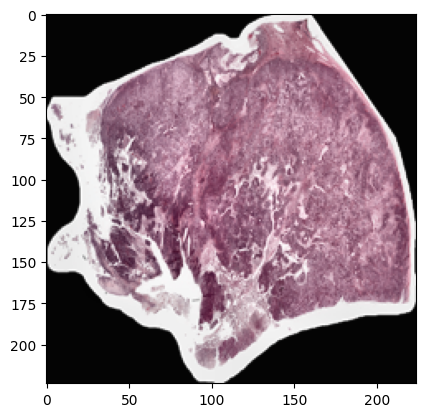

In [35]:
plt.imshow(X_test[0])

In [36]:
prediction = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [37]:
pred_idx = np.nonzero(prediction)[1]
toxic_level = ['CC','EC','HGSC','LGSC','MC']
result = list(toxic_level[i] for i in pred_idx )
print(result)

['HGSC']


In [38]:
test_df['image_id'].tolist()

[41]

In [39]:
df_predictions = pd.DataFrame({'image_id': test_df['image_id'].tolist(),
                               'label': result})

In [40]:
df_predictions

,image_id,label
0,41,HGSC


In [41]:
df_predictions.to_csv('/kaggle/working/submission.csv', index=None)